# Kaggle. Классификатор текстов.

Ссылка на соревнование: https://www.kaggle.com/c/avito-category-prediction/overview

Мы будем работать с датасетом объявлений Avito. Нам предстоит по заголовку и тексту объявления предсказывать категорию объявления.

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,title,description,Category_name,Category
0,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 год","Комплект ЭБУ (мозги, компьютер мотора, двигате...",Запчасти и аксессуары,10
1,Утюг утп 1000 ватт СССР 1987 год,Продам/\n Фото № 1-2 /\n /\nУтюг УТП 1000 ватт...,Бытовая техника,21
2,Возвму машину с выкупом,Возьму машину в аренду с последующим выкупом н...,Предложение услуг,114
3,Полусапожки,"полусапожки в отличном состоянии, один раз оде...","Одежда, обувь, аксессуары",27
4,Босоножки кожаные,"Кожаные(натур) босоножки Karlo Pasolini, 40 рр...","Одежда, обувь, аксессуары",27


✅ Посмотрим на размер нашего датасета (train)

In [4]:
train.shape

(4234042, 4)

✅ Есть ли в данных пропуски

In [5]:
train.isnull().any().any()

True

✅ Посмотрим к каких столбцах есть пропуски

In [6]:
nulls = train.isnull().sum()
nulls = nulls[nulls>0]
nulls

description    2
dtype: int64

✅ Какого типа пропуски?

In [7]:
for col in train:
    if train[col].isnull().sum() > 0:
        print(col, ":", train[col].dtypes)

description : object


✅ Заполним пропуски пустой строкой

In [3]:
import numpy as np
train = train.replace(np.nan, '', regex=True)

✅ Пропусков больше нет

In [4]:
train.isnull().any().any()

False

**Сконкатенируем заголовок и описание в единую строку и поместим результат в отдельный столбец. Таким образом мы будет работать с одним текстом, а не с двумя.**

✅ Сконкатенируем заголовок и описание и создадим отедьный столбец

In [5]:
train['title & description'] = [' '.join([str(x), y]) for x, y in zip(train['title'], train['description'])]

✅ Удалим столбцы "title" и "description", так как данные по ним уже хранятся в раннее созданом столбце 'title & description'

In [6]:
train = train.drop("title", axis=1)
train = train.drop("description", axis=1)

✅ Посмотрим как теперь выглядят наши данные

In [12]:
train

,Category_name,Category,title & description
0,Запчасти и аксессуары,10,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 ..."
1,Бытовая техника,21,Утюг утп 1000 ватт СССР 1987 год Продам/\n Фот...
2,Предложение услуг,114,Возвму машину с выкупом Возьму машину в аренду...
3,"Одежда, обувь, аксессуары",27,"Полусапожки полусапожки в отличном состоянии, ..."
4,"Одежда, обувь, аксессуары",27,Босоножки кожаные Кожаные(натур) босоножки Kar...
...,...,...,...
4234037,Мотоциклы и мототехника,14,Мопед Дельта Мотоланд 70 кубиков Продам новый ...
4234038,Телефоны,84,Xiaomi A2 4/64 почти новый (б/у 3 дня) Xiaomi ...
4234039,Детская одежда и обувь,29,Шерстяной комбинезон Joha В отличном состоянии...
4234040,Детская одежда и обувь,29,Джинсы фирмы Zara р.152 Новые


## Изучаем данные

1. ✅ Сколько всего уникальных классов необходимо предсказать

In [13]:
train["Category_name"].nunique()

50

2. ✅ Столбчатая диаграмма распределения по классам (нормализованная). 

In [14]:
category = train["Category_name"].value_counts() / len(train)

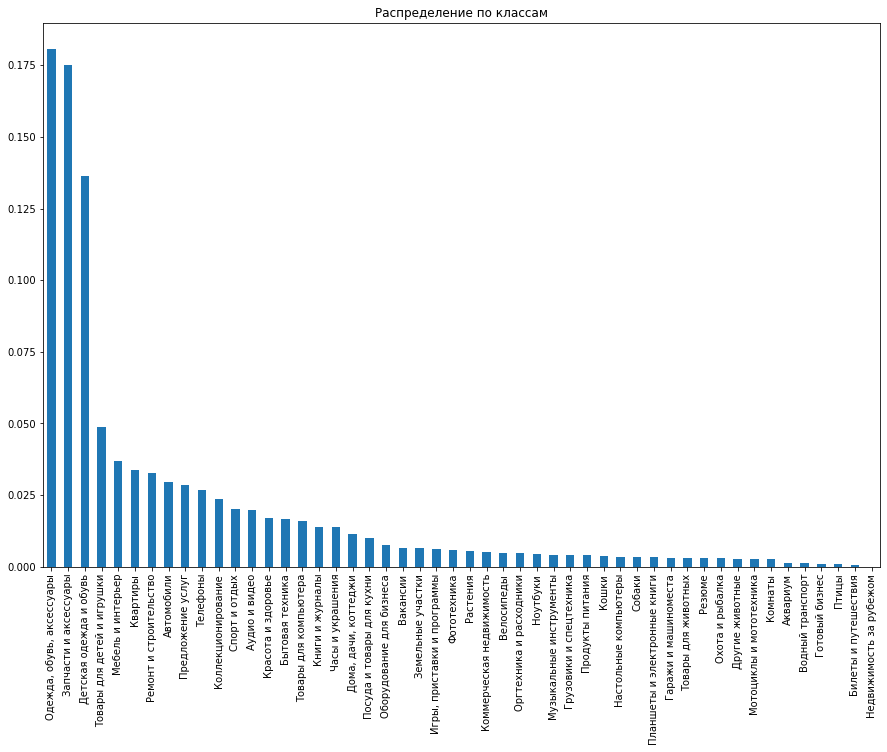

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,10))
train['Category_name'].value_counts().apply(lambda x: x/train['Category_name'].shape[0]).plot(kind='bar', ax=ax)
plt.title('Распределение по классам')
plt.show()

3.✅ Посмотрим на дисбаланс классов

In [16]:
category = train["Category_name"].value_counts() / len(train)

- Самая большая доля в выборке у класса "Одежда, обувь, аксессуары"

In [17]:
category.nlargest(1)

Одежда, обувь, аксессуары    0.180707
Name: Category_name, dtype: float64

- Самая маленькая доля в выборке у класса "Недвижимость за рубежом"

In [18]:
category.nsmallest(1)

Недвижимость за рубежом    0.000039
Name: Category_name, dtype: float64

- Соответственно, категория "Одежда, обувь, аксессуары" встречается примерно в 4637 раза чаще, чем "Недвижимость за рубежом"

In [19]:
max(category)/min(category) # дисбаланс

4637.090909090909

**Поработаем только с train частью**

(Для test части нам неизвестны истинные значения, и они понадобятся только тогда, когда мы будем отправлять решение на Kaggle)

1. Предобработаем данные (train часть) с помощью CountVectorizer.
2. Посмотрим на размер матрицы


In [20]:
Train = list(train['title & description'])

✅ Проработка данных с помощью CountVectorizer

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(Train)
#X.toarray()

✅ Размер полученной матрицы (результат обработки train CountVectorizerом)

In [23]:
X

<4234042x2125805 sparse matrix of type '<class 'numpy.int64'>'
	with 150918485 stored elements in Compressed Sparse Row format>

**Заметим, что матрица получилась огромной.**


**В тексте есть множество специальных символов.**

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле _vocabulary инстанса этого класса.

1. Найдем в этом словаре все слова, которые начинаются на цифру.

2. Найдем все слова, которые начинаются на символы пунктуации.

✅ Посмотрим на ключи в нашем словаре

In [24]:
v=list(vectorizer.vocabulary_.keys())

1.✅ На цифру начинается 610944 слово

In [25]:
words1 = []
for line in v:
    words1 += [w for w in line.split() if w[0].isdigit()]
len(words1)

610944

2.✅ На символы пунктуации начинается 2043 слова (все символы пунктуации, которые находит мой алгоритм представлены в ячейке ниже)

In [26]:
import string
res=string.punctuation
res

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
words2 = []
for line in v:
    words2 += [w for w in line.split() if w[0] in res]
len(words2)

2043

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. 

У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor.
- preprocessor применится в самом начале к каждой строке вашего датасета,
- tokenizer же должен принять строку и вернуть токены.


**Напишем кастомный токенайзер, которые сделает все, что нам нужно:**

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью word_tokenizer из пакета nltk
2. Удалит все токены содержащие числительные и пунктуацию
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords('russian')
4. Проведет стемминг с помощью SnowballStemmer


✅ Вынесла в отдельную ячейку все библиотеки, которые мне пригодились при написании функции

In [7]:
import nltk
nltk.download('punkt')
import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop_words = stopwords.words("russian")
from nltk.stem import SnowballStemmer
from nltk.stem.snowball import SnowballStemmer 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\krup1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krup1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Мой токенайзер:

In [8]:
def count_iterable(i):
    return sum(1 for e in i)


def My_tokenizer (text):
    #0
    text = text.lower()
    
    #1
    tknzr = word_tokenize(str(text))
    
    #2
    tokenizer = RegexpTokenizer(r'\w+')   # пунктуация
    text = tokenizer.tokenize(str(text)) 
    
    filtered_tokens = []    #цифры
    filtered_tokens = (token for token in text if not token.isdigit())
    
    #3
    f_tokens = []
    f_tokens = (token for token in filtered_tokens if token not in stop_words)

    #4
    stemmer = SnowballStemmer('russian')
    tokens = []
    for i in f_tokens:
        stemmed_example = stemmer.stem(i)
        tokens += [stemmed_example]
    
    
    return(tokens)

Не обращайте внимание на библиотеку time, она мне требовалась для оптимизации токинайзера.

✅ Проверим работу функции на самом первом описании товара в датасете (первую строчку занесла в переменную listt, ячейка ниже)

In [41]:
import time

a  = My_tokenizer(listt)

start_time = time.time()

for i in range(10000):
    My_tokenizer(listt)
print("--- %s seconds ---" % (time.time() - start_time))
a

--- 84.1736786365509 seconds ---


['эб',
 'renault',
 'nissan',
 'dci',
 'delphi',
 'год',
 'комплект',
 'эб',
 'мозг',
 'компьютер',
 'мотор',
 'двигател',
 'коммутатор',
 'электрон',
 'блок',
 'управлен',
 'двигател',
 'компьютер',
 'мотор',
 'рен',
 'kangoo',
 'канг',
 'канг',
 'мега',
 'сценик',
 'laguna',
 'лагун',
 'clio',
 'кли',
 'nissan',
 'micra',
 'нисса',
 'микр',
 'друг',
 'рен',
 'нисса',
 'дизел',
 'топливн',
 'аппаратур',
 'делф',
 'б',
 'оригина',
 'отличн',
 'состоян',
 'проверен',
 'гарант',
 'запчаст',
 'предоставля',
 'гарант',
 'возможн',
 'установк',
 'подробн',
 'раздел',
 'компан',
 'дорож',
 'сво',
 'репутац',
 'торгу',
 'легальн',
 'контрактн',
 'запчаст',
 'дета',
 'налич',
 'таможен',
 'документ',
 'запчаст',
 'автомобил',
 'пробег',
 'росс',
 'отправля',
 'друг',
 'регион',
 'таможен',
 'союз',
 'транспортн',
 'компан',
 'наложн',
 'платеж']

In [38]:
listt = train['title & description'][0]

### Оценка качества

1. Возьмем случайные 500к строк из датасета. Построим по ним CountVectorizer с применением  токенизатора.
2. Разобьем полученную матрицу на train, test в отношении 4 к 1. Не забываем про target переменную.
3. Обучим SGDClassifier на полученной выборке.
4. Посчитаем метрику accuracy

- Возьмем случайные 500к строк, перед этим зафиксируем random.seed

In [9]:
np.random.seed(42)

In [10]:
tr = train.sample(500000)
tr

,Category_name,Category,title & description
382220,Мебель и интерьер,20,Прихожая В хорошем состоянии. Торг
397529,Запчасти и аксессуары,10,Кордиант 215/55/16 Летние Кордиант 215/55/16 Л...
584569,Мебель и интерьер,20,"Стол Стол, 2 рабочих места . Стол серого цвета..."
2513100,"Одежда, обувь, аксессуары",27,Комбинезон Размер-42/44
1091886,Детская одежда и обувь,29,Ветровка На 2 года
...,...,...,...
3308445,Коллекционирование,36,"Бахилы озк, новые, р 1.2.3 ткань бцк Бахилы ОЗ..."
2960243,Запчасти и аксессуары,10,Тойота матрикс бампер передний от тойоты матри...
2819432,"Одежда, обувь, аксессуары",27,"Куртка женская Натуральная замшевая куртка, ос..."
619198,Часы и украшения,28,Часы Восток СССР зеленые редкие Люкс Часы в от...


- Построим по случайным 500к строкам CountVectorizer

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = My_tokenizer)
X = vectorizer.fit_transform(tr['title & description'])

- Посмотрим на размер нашей матрицы

In [68]:
X

<500000x332849 sparse matrix of type '<class 'numpy.int64'>'
	with 14221114 stored elements in Compressed Sparse Row format>

- Переходим к обучению. Разобьем нашу выборку на train и test

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

In [70]:
x_train, x_test, y_train, y_test = train_test_split(X, tr.Category, random_state=13, test_size=0.2)

- Обучаем SGDClassifier на полученной выборке

In [71]:
clf = SGDClassifier()
clf.fit(x_train, y_train)
pred_CountVectorizer = clf.predict(x_test)

- Считаем accuracy

In [72]:
from sklearn.metrics import accuracy_score

In [73]:
print(accuracy_score(y_test, pred_CountVectorizer))

0.86048


### ✅ CountVectorizer - 0.86048

### Оценка качетва 2.0
1. Повторим все то же самое, но с tf-idf векторизатором. Посмотрим на изменение качетсва.
2. Мы можем еще сильнее уменьшите размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничим максимальный df в параметрах TfIdfVectorizer, верхнюя граница =  0.9. Посмотрим на изменение в качетсве


1)

- Подключим необходимую библеотеку

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

- Применяем TfidfVectorizer

In [12]:
vectorizer = TfidfVectorizer(tokenizer = My_tokenizer)
X = vectorizer.fit_transform(tr['title & description'])

In [13]:
X

<500000x332849 sparse matrix of type '<class 'numpy.float64'>'
	with 14221114 stored elements in Compressed Sparse Row format>

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, tr.Category, random_state=13, test_size=0.2)

- Обучаем

In [45]:
clf = SGDClassifier()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

- Считаем accuracy

In [46]:
print(accuracy_score(y_test, pred))

0.8376


### ✅ TfidfVectorizer - 0.8376

**Видим, что доля правильных ответов стала меньше почти на 0.03 по сравнению с CountVectorizerом**

2)

- Применяем TfidfVectorizer с верхней границей 0.9

In [14]:
vectorizer = TfidfVectorizer(tokenizer = My_tokenizer, max_df = 0.9)
X = vectorizer.fit_transform(tr['title & description'])

In [15]:
X

<500000x332849 sparse matrix of type '<class 'numpy.float64'>'
	with 14221114 stored elements in Compressed Sparse Row format>

- Обучаем

In [48]:
x_train, x_test, y_train, y_test = train_test_split(X, tr.Category, random_state=13, test_size=0.2)

In [49]:
clf = SGDClassifier()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

- Считаем accuracy

In [50]:
print(accuracy_score(y_test, pred))

0.8376


### ✅TfidfVectorizer (0.9) - 0.8376

**Видим, что доля правильных ответов стала меньше почти на 0.03 по сравнению с CountVectorizerом, однако качество при уставленной верхней границы осталось прежним.**

## Уменьшаем количество признаков с помощью hashing trick
Его суть в том, то мы случайно группируем признаки и складываем их, а потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Давайте проверим этот трюк в нашем сеттинге.

1)

In [51]:
from sklearn.feature_extraction.text import HashingVectorizer

In [52]:
vectorizer = HashingVectorizer(tokenizer = My_tokenizer, n_features=30000)
X = vectorizer.fit_transform(tr['title & description'])

C:\Users\krup1\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, tr.Category, random_state=13, test_size=0.2)

In [54]:
clf = SGDClassifier()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

In [55]:
print(accuracy_score(y_test, pred))

0.82036


### ✅HashingVectorizer - 0.82036

**Видим, что доля правильных ответов стала меньше почти на 0.04 по сравнению с CountVectorizerом, и на почти 0.01 меньше, чем у TfidfVectorizer.**

## Формируем файл с предсказаниями

### Обрабатываем test

#### ✅Избавляемся от пропусков в данных. Проверяем их наличие. Смотрим на тип пропусков, заменяем пропуски пустой строкой.

In [75]:
test.isnull().any().any()

True

In [77]:
nulls = test.isnull().sum()
nulls = nulls[nulls>0]
nulls

description    1
dtype: int64

In [79]:
for col in test:
    if test[col].isnull().sum() > 0:
        print(col, ":", test[col].dtypes)

description : object


In [80]:
import numpy as np
test = test.replace(np.nan, '', regex=True)

✅ Пропусков нет

In [81]:
test.isnull().any().any()

False

#### ✅ Сконкатенируем заголовок и описание в единую строку и поместим результат в отдельный столбец

In [84]:
test['title & description'] = [' '.join([str(x), y]) for x, y in zip(test['title'], test['description'])]

✅ Удалим столбцы, которые объединили в один 

In [85]:
test = test.drop("title", axis=1)
test = test.drop("description", axis=1)

- Посмотрим

In [86]:
test

,itemid,title & description
0,1778449823,Мастерка Мастерка фирмы форвард. Белого цвета....
1,1677656962,"Зимние сапоги Продаю зимние сапоги, в хорошем ..."
2,1758182804,Видеонаблюдение 8 камер В комплект Atis AMD-2M...
3,1689811299,Запчасти для GLE Запчасти GLE
4,1804706240,Бластер nerf Состояние 5+/\nПродаю потому что ...
...,...,...
1411343,902146704,Бетоносмеситель Россия бсэ-140 чугун Бетономеш...
1411344,1799983289,Разношрокие колеса R19 оригинал Porsche Paname...
1411345,1177237748,Комбенз зимний размер Комбензон на овчине .Под...
1411346,1793055786,Смартфон Honor 5C В отличном состоянии. Исполь...


✅ Обработаем test с помощью **CountVectorizer** (выбрала его, так как с его использованием качетво правильных ответов было мксимальным по сравнению с другими методами)

In [102]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = My_tokenizer)
bow_t = vectorizer.fit_transform(tr['title & description'])    # обучаем токенайзер на трейне
bow_test = vectorizer.transform(test['title & description'])   # применяем на тесте

### 🆘 Предсказываем категорию товаров по тестовой выборке 

In [104]:
clf = SGDClassifier()
clf.fit(x_train, y_train)
pred_CountVectorizer = clf.predict(bow_test)

- Далее привожу данные к виду, как указано было в примере поссылки

In [119]:
df = pd.DataFrame(data=np.array(test.itemid), columns = ['Id'])

In [120]:
df = pd.concat([df, pd.DataFrame(pred_CountVectorizer)], axis = 1)

In [121]:
df = df.rename(columns = {0: 'Category'})

In [122]:
df

,Id,Category
0,1778449823,29
1,1677656962,29
2,1758182804,32
3,1689811299,10
4,1804706240,30
...,...,...
1411343,902146704,19
1411344,1799983289,10
1411345,1177237748,29
1411346,1793055786,84


###  Запишем в csv файл поссылку

In [123]:
df.to_csv('predict_Rvach_IAD_1.csv', index = False)